# Making a regression model for the wine quality dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

plt.style.use('seaborn')

In [3]:
def load_data():
    file = '../data/wine/winequality-red.csv'
    return pd.read_csv(file)
wine = load_data()

In [4]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
wine['quality'] = wine['quality'].astype(np.float)

In [7]:
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

No missing values, no need to fill values

In [8]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   float64
dtypes: float64(12)
memory usage: 150.0 KB


In [9]:
wine['quality'].value_counts()

5.0    681
6.0    638
7.0    199
4.0     53
8.0     18
3.0     10
Name: quality, dtype: int64

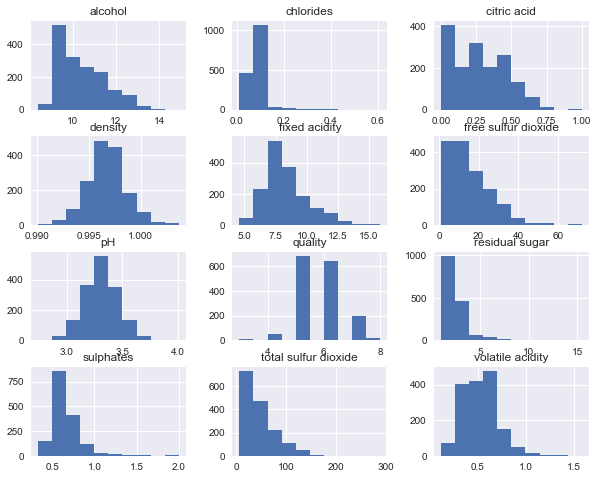

In [10]:
wine.hist(figsize=(10, 8))
plt.show()

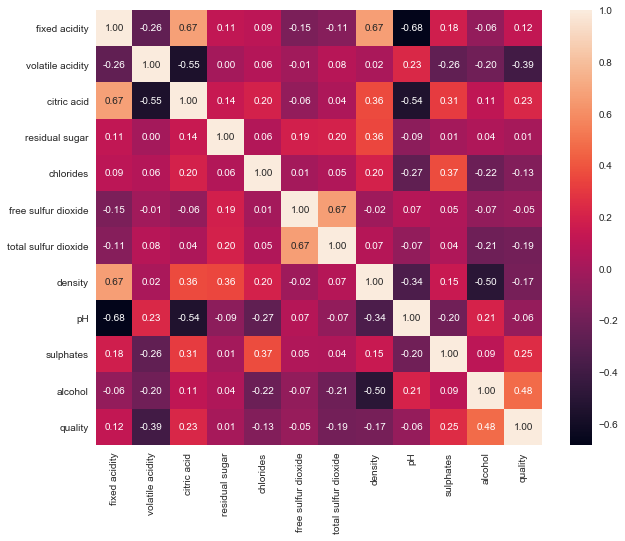

In [11]:
ax, fig = plt.subplots(figsize=(10, 8))
sns.heatmap(wine.corr(), annot=True, fmt='.2f')
plt.show()

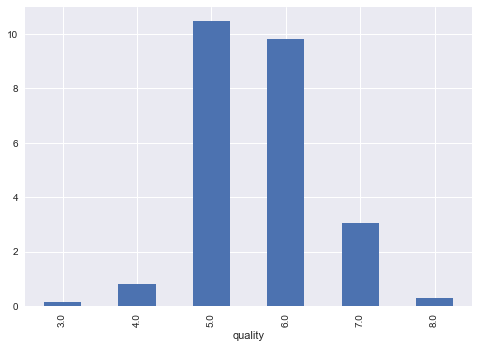

In [12]:
pd.crosstab(wine.alcohol, wine.quality).mean().plot.bar()
plt.show()

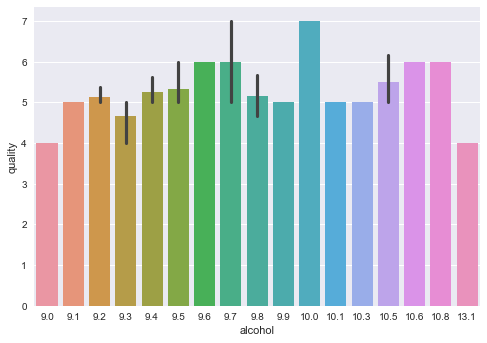

In [13]:
sns.barplot('alcohol','quality', data=wine[:50])
plt.show()

In [20]:
X = wine.drop('quality', axis=1)
y = wine['quality'].copy()

lin_scaled = Pipeline([
    ('scaled', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3)),
])

X_transformed = lin_scaled.fit_transform(X)

X_prep, X_test_prep, y_prep, y_test_prep = train_test_split(X_transformed, y,
                                                    test_size=0.2, random_state=7)
X_prep.shape, X_test_prep.shape, y_prep.shape, y_test_prep.shape

((1279, 364), (320, 364), (1279,), (320,))

## First set of models

In [21]:
# Linear model 
lin_reg = LinearRegression().fit(X_prep, y_prep)
lin_reg.score(X_prep, y_prep)

0.6528876310897385

In [22]:
# Ridge 
ridge_reg = Ridge().fit(X_prep, y_prep)
ridge_reg.score(X_prep, y_prep)

0.6470508516326424

In [59]:
# Checking it's score with a cross validation set
lin_cvs = cross_val_score(lin_reg, X_transformed, y, cv=5,
                          scoring='neg_mean_absolute_error', n_jobs=-1)
print(-lin_cvs)

[1.14268938 1.07837349 0.76416114 1.0202272  0.93827246]


In [60]:
print(f'Mean of score : {np.mean(-lin_cvs)}\n Std of score : {np.std(lin_cvs)}')

Mean of score : 0.9887447326678089
 Std of score : 0.13092643377842922


In [58]:
ridge_cvs = cross_val_score(ridge_reg, X_transformed, y, cv=5,
                            scoring='neg_mean_absolute_error', n_jobs=-1)
print(-ridge_cvs)

[1.05268002 0.90894981 0.7090995  0.97795703 0.89404114]


In [54]:
print(f'Mean of score : {np.mean(-ridge_cvs)}\n Std of score : {np.std(-ridge_cvs)}')

Mean of score : 0.9085454996910967
 Std of score : 0.11452682279617772


In [35]:
# Apllying GridSearchCv on the Ridge models
grid_params = {
    'alpha':[0.1, 1.0, 10.0, 100],
    'max_iter': [10, 50, 100],
    'solver':['auto', 'lsqr', 'cholesky']    
}
grid_model = GridSearchCV(ridge_reg, param_grid=grid_params, n_jobs=-1, cv=5)
grid_model.fit(X_prep, y_prep)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0, 100],
                         'max_iter': [10, 50, 100],
                         'solver': ['auto', 'lsqr', 'cholesky']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [36]:
grid_model.best_params_

{'alpha': 100, 'max_iter': 10, 'solver': 'lsqr'}

In [38]:
grid_model.score(X_prep, y_prep)

0.4069496604010894

# Second Model Set 

A random forest and a decision tree model would be created
first before creating an ensemble tree with both of them

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1279, 11), (320, 11), (1279,), (320,))

In [40]:
dec_reg = DecisionTreeRegressor().fit(X_train, y_train)
dec_reg.score(X_train, y_train)

1.0

In [41]:
rf_reg = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
rf_reg.score(X_train, y_train)

0.9254575461016

In [42]:
np.random.seed(7)
voting_reg = VotingRegressor(estimators=[
    ('dec_reg', dec_reg),
    ('rf_reg',rf_reg),
], n_jobs=-1)

for vote_clf in (dec_reg, rf_reg, voting_reg):
    vote_clf.fit(X_train, y_train)
    print(f'{vote_clf.__class__.__name__} : {vote_clf.score(X_train, y_train):.2f}')

DecisionTreeRegressor : 1.00
RandomForestRegressor : 0.93
VotingRegressor : 0.98


Since all models produce high score with their baseline hyperparameter, i would build a bagging model with the VotingRegressor model.

In [43]:
# running a bagging model with it's base hyperparameter setting , oob_score set to True
bag_rg = BaggingRegressor(voting_reg,oob_score=True).fit(X_train, y_train)
print(bag_rg.score(X_train, y_train))
print(f'OOB SCORE : {bag_rg.oob_score_:.2f}')

/home/eclipse/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.8592322621692949
OOB SCORE : -0.11


# Performance measurement and Hyperparameter Tuning

In [68]:
cross_score = cross_val_score(dec_reg, X_transformed, y, 
                              scoring='neg_mean_absolute_error', n_jobs=-1, 
                             cv=5)
print(-cross_score)

[0.65       0.665625   0.59375    0.684375   0.68338558]


In [69]:
# mean and standard devaition score of the cross_val_score output
print(f'Mean of score : {np.mean(-cross_score)}\n Std of score : {np.std(-cross_score)}')

Mean of score : 0.6554271159874607
 Std of score : 0.03333818458777669


#  

In [70]:
cross_score = cross_val_score(rf_reg, X_transformed, y, 
                              scoring='neg_mean_absolute_error', n_jobs=-1, 
                             cv=5)
print(-cross_score)

[0.52953125 0.5291875  0.50765625 0.53675    0.51952978]


In [71]:
# mean and standard devaition score of the cross_val_score output
print(f'Mean of score : {np.mean(-cross_score)}\n Std of score : {np.std(-cross_score)}')

Mean of score : 0.5245309561128526
 Std of score : 0.01005742349421323


In [96]:
np.random.seed(7)
grid_params = {
    'max_features':['auto', 'log2', 'sqrt', 0.6, 1],
    'max_depth': [3, 5],
    'min_samples_leaf':[10, 15, 25, 50, 100]
}

dec_model = GridSearchCV(dec_reg, param_grid=grid_params,
                          scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
dec_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5],
                         'max_features': ['auto', 'log2', 'sqrt', 0.6, 1],
                         'min_sample

In [180]:
final_model = dec_model.best_estimator_

In [179]:
# results = dec_model.cv_results_
# for result, attr in zip(results['mean_test_score'], results['params']):
#     print(np.sqrt(-result), attr)

In [114]:
score = np.sqrt(-dec_model.best_score_)
score

0.7300381460356338

In [102]:
np.random.seed(7)
grid_params = {
    'max_features':['auto', 'log2', 'sqrt', 0.6, 1],
    'max_depth': [3, 5],
    'min_samples_leaf':[10, 15, 25, 50, 100]
}

rf_model = GridSearchCV(rf_reg, param_grid=grid_params,
                          scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [184]:
np.sqrt(-rf_model.best_score_)

0.7107888014131858

In [181]:
# results = rf_model.cv_results_
# for result, attr in zip(results['mean_test_score'], results['params']):
#     print(np.sqrt(-result), attr)

In [178]:
y_pred = final_model.predict(X_train)
score = mean_absolute_error(y_train, y_pred)
score

0.5033034436922238

In [185]:
y_preds = final_model.predict(X_test)
score = mean_absolute_error(y_test, y_preds)
score

0.48269811044877464

In [216]:
test = np.array(wine.iloc[1573, :11]).reshape(1,-1)
score = final_model.predict(test)
print(f'Prediction {score}')

Prediction [5.97402597]


In [215]:
wine.loc[1573, 'quality']

6.0

Conclusion : Wine quality cant be predicted using a regression algorithm 